In [22]:
import folium
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from math import pi, cos
from dataclasses import dataclass
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_pickle, load_csv, load_json
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()


@dataclass(frozen=True)
class TargetScores:
    """
    dataclass object for storing a given score methodology.
    Score depends on the set of selected hostnames.
    """

    score_config: dict
    hostnames: list[str]
    cdns: list[str]
    score_answers: dict[list]
    score_answer_subnets: dict[list]
    score_answer_bgp_prefixes: dict[list]


@dataclass(frozen=True)
class EvalResults:
    """
    dataclass object for storing a given results methodology.
    Results depends on score calculation.
    """

    target_scores: TargetScores
    results_answers: list[dict]
    results_answer_subnets: list[dict]
    results_answer_bgp_prefixes: list[dict]


def get_median_dist_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["d_error"] for r in target_results.values()]),
        2,
    )


def get_median_rtt_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["rtt"] for r in target_results.values()]),
        2,
    )

In [23]:
ref_shortest_ping_results = load_pickle(
    path_settings.RESULTS_PATH / "results_ref_shortest_ping.pickle"
)

In [24]:
imc_baseline_results = load_json(
    path_settings.RESULTS_PATH / "round_based_algo_file.json"
)

# Geoloc Error

2024-04-18 07:46:58.302 | INFO     | __main__:<module>:31 - main_org_threshold=0.2, bgp_prefixes_threshold=2
2024-04-18 07:46:58.303 | INFO     | __main__:<module>:38 - len(total_hostnames)=2495
2024-04-18 07:46:58.313 | INFO     | __main__:<module>:70 - ECS shortest ping:: jaccard, 5 VPs, median_error=12.36 [km], 2495 hostnames, 0.2, 2
2024-04-18 07:46:58.315 | INFO     | __main__:<module>:70 - ECS shortest ping:: jaccard, 10 VPs, median_error=8.78 [km], 2495 hostnames, 0.2, 2
2024-04-18 07:46:58.317 | INFO     | __main__:<module>:70 - ECS shortest ping:: jaccard, 50 VPs, median_error=6.22 [km], 2495 hostnames, 0.2, 2
2024-04-18 07:46:58.320 | INFO     | __main__:<module>:91 - Zero ping:: jaccard, median_error=50.1 [km]
2024-04-18 07:46:58.321 | INFO     | __main__:<module>:93 - ###############################
2024-04-18 07:46:58.673 | INFO     | __main__:<module>:31 - main_org_threshold=0.2, bgp_prefixes_threshold=5
2024-04-18 07:46:58.680 | INFO     | __main__:<module>:38 - len(tota

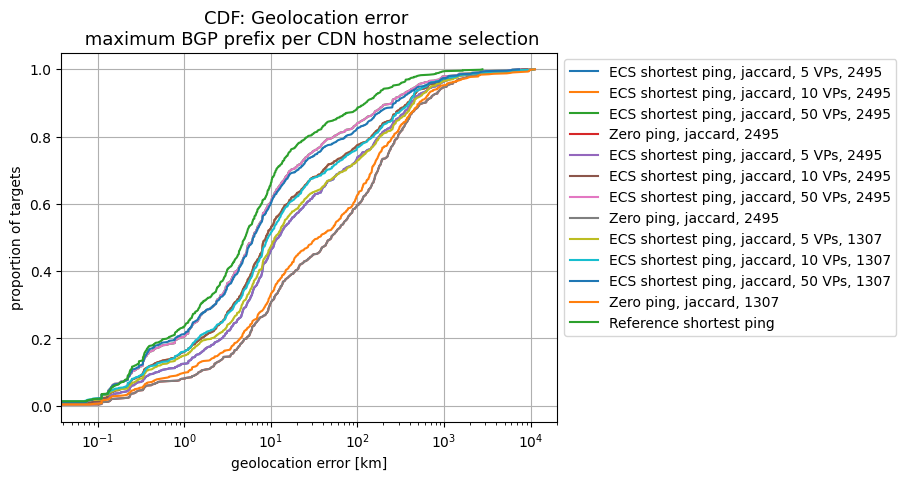

In [35]:
eval_files = [
    # "results__AMAZON-02_1_greedy_per_cdn.pickle",
    # "results__AMAZON-02_5_greedy_per_cdn.pickle",
    # "results__AMAZON-02_10_greedy_per_cdn.pickle",
    # "results__AMAZON-02_100_greedy_per_cdn.pickle",
    # "results__AMAZON-02_500_greedy_per_cdn.pickle",
    # "results__AMAZON-02_1000_greedy_per_cdn.pickle",
    # "results__all_cdns_10_hostname_per_cdn_max_bgp_prefix.pickle",
    "results__10_hostname_per_cdn_per_ns_major_cdn_threshold_0.2_bgp_prefix_threshold_2.pickle",
    "results__10_hostname_per_cdn_per_ns_major_cdn_threshold_0.2_bgp_prefix_threshold_5.pickle",
    "results__10_hostname_per_cdn_per_ns_major_cdn_threshold_0.6_bgp_prefix_threshold_2.pickle",
]

fig, ax1 = plt.subplots(1, 1)

for file in eval_files:

    eval: EvalResults = load_pickle(path_settings.RESULTS_PATH / file)

    ref_shortest_ping_m_d = get_median_dist_error(
        ref_shortest_ping_results, "ref_shortest_ping_vp"
    )

    results_answer_subnet = eval.results_answer_bgp_prefixes

    score_config = eval.target_scores.score_config

    main_org_threshold = score_config["main_org_threshold"]
    bgp_prefixes_threshold = score_config["bgp_prefixes_threshold"]

    logger.info(f"{main_org_threshold=}, {bgp_prefixes_threshold=}")

    total_hostnames = set()
    for cdn, hostnames in score_config["hostname_per_cdn"].items():
        # logger.info(f"CDN:: {cdn}, {len(hostnames)} hostnames selected")
        total_hostnames.update(hostnames)

    logger.info(f"{len(total_hostnames)=}")

    d_error_per_budget = defaultdict(dict)
    for target, target_results_per_metric in results_answer_subnet.items():
        for metric, target_results in target_results_per_metric[
            "result_per_metric"
        ].items():
            if not metric in ["jaccard"]:
                continue
            for budget, ecs_shortest_ping_vp in target_results[
                "ecs_shortest_ping_vp_per_budget"
            ].items():
                try:
                    d_error_per_budget[metric][budget].append(
                        ecs_shortest_ping_vp["d_error"]
                    )
                except KeyError:
                    d_error_per_budget[metric][budget] = [
                        ecs_shortest_ping_vp["d_error"]
                    ]

    for metric in d_error_per_budget:
        for budget, d_errors in d_error_per_budget[metric].items():
            if budget in [5, 10, 50]:
                x, y = ecdf([d for d in d_errors])
                m_error = round(np.median(d_errors), 2)
                ax1.plot(
                    x,
                    y,
                    label=f"ECS shortest ping, {metric}, {budget} VPs, {len(eval.target_scores.hostnames)}",
                )

                logger.info(
                    f"ECS shortest ping:: {metric}, {budget} VPs, median_error={round(m_error, 2)} [km], {len(eval.target_scores.hostnames)} hostnames, {main_org_threshold}, {bgp_prefixes_threshold}"
                )

    no_ping_per_metric = defaultdict(list)
    for target, target_results_per_metric in results_answer_subnet.items():
        for metric, target_results in target_results_per_metric[
            "result_per_metric"
        ].items():
            no_ping_per_metric[metric].append(target_results["no_ping_vp"]["d_error"])

    for metric, cdf in no_ping_per_metric.items():
        x, y = ecdf([r for r in cdf])
        ax1.plot(
            x, y, label=f"Zero ping, {metric}, {len(eval.target_scores.hostnames)}"
        )
        m_error = round(
            np.median([r for r in cdf]),
            2,
        )

        logger.info(f"Zero ping:: {metric}, median_error={round(m_error, 2)} [km]")

    logger.info("###############################")


ref_shortest_ping_m_d = get_median_dist_error(
    ref_shortest_ping_results, "ref_shortest_ping_vp"
)

x, y = ecdf(
    [r["ref_shortest_ping_vp"]["d_error"] for r in ref_shortest_ping_results.values()]
)
ax1.plot(x, y, label=f"Reference shortest ping")

logger.info(
    f"Reference shortest ping:: median_error={round(ref_shortest_ping_m_d, 2)} [km]"
)

# for nb_init_vps in imc_baseline_results:

#     x, y = ecdf(
#         [d[1] for d in imc_baseline_results[nb_init_vps] if d[1] and d[1] > 0.01]
#     )
#     m_error = round(
#         np.median([d[1] for d in imc_baseline_results[nb_init_vps] if d[1]]), 2
#     )
#     ax1.plot(
#         x,
#         y,
#         label=f"IMC baseline shortest ping, {nb_init_vps} init VPs",
#     )

#     logger.info(
#         f"ECS shortest ping:: IMC baseline shortest ping, {nb_init_vps} init VPs, median_error={round(m_error, 2)} [km]"
#     )

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.legend(bbox_to_anchor=(1, 1))
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

2024-04-18 07:16:03.394 | INFO     | __main__:<module>:24 - CDN:: GOOGLE, 1 hostnames selected
2024-04-18 07:16:03.400 | INFO     | __main__:<module>:54 - ECS shortest ping:: intersection, median_error=50.62 [km]
2024-04-18 07:16:03.403 | INFO     | __main__:<module>:54 - ECS shortest ping:: jaccard, median_error=34.18 [km]
2024-04-18 07:16:03.409 | INFO     | __main__:<module>:75 - Zero ping:: intersection, median_error=811.07 [km]
2024-04-18 07:16:03.411 | INFO     | __main__:<module>:75 - Zero ping:: jaccard, median_error=492.61 [km]
2024-04-18 07:16:04.500 | INFO     | __main__:<module>:24 - CDN:: GOOGLE, 5 hostnames selected
2024-04-18 07:16:04.506 | INFO     | __main__:<module>:54 - ECS shortest ping:: intersection, median_error=38.25 [km]
2024-04-18 07:16:04.508 | INFO     | __main__:<module>:54 - ECS shortest ping:: jaccard, median_error=37.2 [km]
2024-04-18 07:16:04.513 | INFO     | __main__:<module>:75 - Zero ping:: intersection, median_error=461.36 [km]
2024-04-18 07:16:04.5

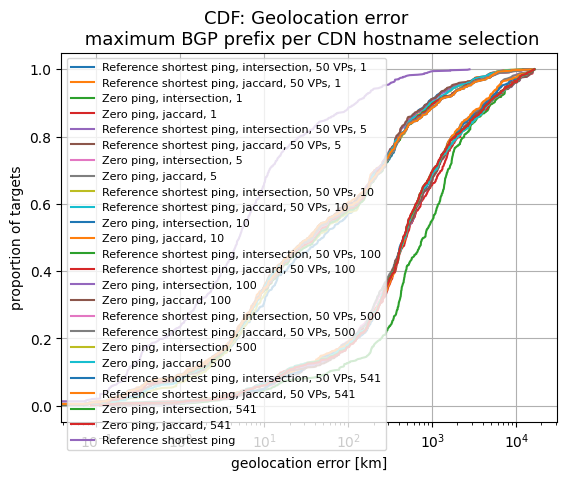

In [26]:
eval_files = [
    "results__GOOGLE_1_max_bgp_prefixes.pickle",
    "results__GOOGLE_5_max_bgp_prefixes.pickle",
    "results__GOOGLE_10_max_bgp_prefixes.pickle",
    "results__GOOGLE_100_max_bgp_prefixes.pickle",
    "results__GOOGLE_500_max_bgp_prefixes.pickle",
    "results__GOOGLE_541_max_bgp_prefixes.pickle",
]

fig, ax1 = plt.subplots(1, 1)

for file in eval_files:

    eval: EvalResults = load_pickle(path_settings.RESULTS_PATH / file)

    ref_shortest_ping_m_d = get_median_dist_error(
        ref_shortest_ping_results, "ref_shortest_ping_vp"
    )

    results_answer_subnet = eval.results_answer_bgp_prefixes

    score_config = eval.target_scores.score_config
    for cdn, hostnames in score_config["hostname_per_cdn"].items():
        logger.info(f"CDN:: {cdn}, {len(hostnames)} hostnames selected")

    d_error_per_budget = defaultdict(dict)
    for target, target_results_per_metric in results_answer_subnet.items():
        for metric, target_results in target_results_per_metric[
            "result_per_metric"
        ].items():
            for budget, ecs_shortest_ping_vp in target_results[
                "ecs_shortest_ping_vp_per_budget"
            ].items():
                try:
                    d_error_per_budget[metric][budget].append(
                        ecs_shortest_ping_vp["d_error"]
                    )
                except KeyError:
                    d_error_per_budget[metric][budget] = [
                        ecs_shortest_ping_vp["d_error"]
                    ]

    for metric in d_error_per_budget:
        for budget, d_errors in d_error_per_budget[metric].items():
            if budget in [50]:
                x, y = ecdf([d for d in d_errors])
                m_error = round(np.median(d_errors), 2)
                ax1.plot(
                    x,
                    y,
                    label=f"Reference shortest ping, {metric}, {budget} VPs, {len(eval.target_scores.hostnames)}",
                )

                logger.info(
                    f"ECS shortest ping:: {metric}, median_error={round(m_error, 2)} [km]"
                )

    no_ping_per_metric = defaultdict(list)
    for target, target_results_per_metric in results_answer_subnet.items():
        for metric, target_results in target_results_per_metric[
            "result_per_metric"
        ].items():
            no_ping_per_metric[metric].append(target_results["no_ping_vp"]["d_error"])

    for metric, cdf in no_ping_per_metric.items():
        x, y = ecdf([r for r in cdf])
        ax1.plot(
            x, y, label=f"Zero ping, {metric}, {len(eval.target_scores.hostnames)}"
        )
        m_error = round(
            np.median([r for r in cdf]),
            2,
        )

        logger.info(f"Zero ping:: {metric}, median_error={round(m_error, 2)} [km]")

ref_shortest_ping_m_d = get_median_dist_error(
    ref_shortest_ping_results, "ref_shortest_ping_vp"
)

x, y = ecdf(
    [r["ref_shortest_ping_vp"]["d_error"] for r in ref_shortest_ping_results.values()]
)
ax1.plot(x, y, label=f"Reference shortest ping")

logger.info(
    f"Reference shortest ping:: median_error={round(ref_shortest_ping_m_d, 2)} [km]"
)

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

# Latency

2024-04-18 07:16:09.733 | INFO     | __main__:<module>:20 - CDN:: GOOGLE, 18 hostnames selected
2024-04-18 07:16:09.734 | INFO     | __main__:<module>:20 - CDN:: AKAMAI, 54 hostnames selected
2024-04-18 07:16:09.735 | INFO     | __main__:<module>:20 - CDN:: AMAZON, 45 hostnames selected
2024-04-18 07:16:09.736 | INFO     | __main__:<module>:20 - CDN:: APPLE, 9 hostnames selected
2024-04-18 07:16:09.736 | INFO     | __main__:<module>:20 - CDN:: BIGO-AS-AP, 3 hostnames selected
2024-04-18 07:16:09.737 | INFO     | __main__:<module>:20 - CDN:: Taobao, 63 hostnames selected
2024-04-18 07:16:09.738 | INFO     | __main__:<module>:20 - CDN:: ACE-AS-AP, 25 hostnames selected
2024-04-18 07:16:09.738 | INFO     | __main__:<module>:20 - CDN:: ALIBABA-CN-NET, 10 hostnames selected
2024-04-18 07:16:09.739 | INFO     | __main__:<module>:20 - CDN:: INCAPSULA, 11 hostnames selected
2024-04-18 07:16:09.740 | INFO     | __main__:<module>:20 - CDN:: ROBLOX-PRODUCTION, 2 hostnames selected
2024-04-18 07:1

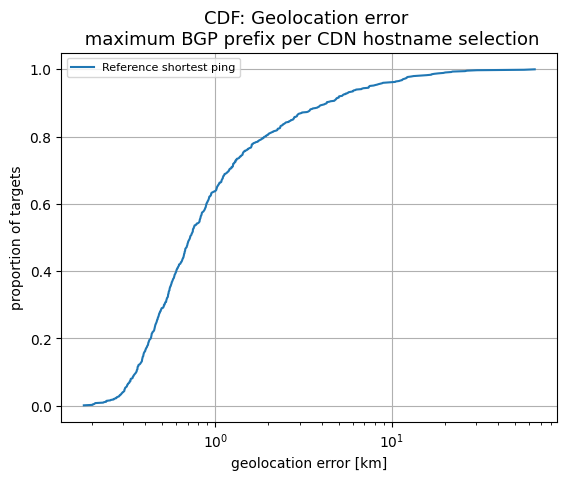

In [27]:
eval_files = [
    # "results__AMAZON-02_1_greedy_per_cdn.pickle",
    # "results__AMAZON-02_5_greedy_per_cdn.pickle",
    # "results__AMAZON-02_10_greedy_per_cdn.pickle",
    # "results__AMAZON-02_100_greedy_per_cdn.pickle",
    # "results__AMAZON-02_500_greedy_per_cdn.pickle",
    "results__all_cdns_10_hostname_per_cdn_max_bgp_prefix.pickle",
]

fig, ax1 = plt.subplots(1, 1)

for file in eval_files:

    eval: EvalResults = load_pickle(path_settings.RESULTS_PATH / file)

    results_answer_subnet = eval.results_answer_subnets

    score_config = eval.target_scores.score_config
    for cdn, hostnames in score_config["hostname_per_cdn"].items():
        logger.info(f"CDN:: {cdn}, {len(hostnames)} hostnames selected")

    d_error_per_budget = defaultdict(list)
    for target, target_results in results_answer_subnet.items():
        for budget, ecs_shortest_ping_vp in target_results[
            "ecs_shortest_ping_vp_per_budget"
        ].items():
            d_error_per_budget[budget].append(ecs_shortest_ping_vp["rtt"])

    for budget, d_errors in d_error_per_budget.items():
        if budget in [50]:
            x, y = ecdf([d for d in d_errors])
            m_error = round(np.median(d_errors), 2)
            ax1.plot(
                x,
                y,
                label=f"Reference shortest ping, {budget} VPs, {len(eval.target_scores.hostnames)}",
            )

            logger.info(f"ECS shortest ping:: median_error={round(m_error, 2)} [km]")


ref_shortest_ping_m_d = get_median_rtt_error(
    ref_shortest_ping_results, "ref_shortest_ping_vp"
)

x, y = ecdf(
    [r["ref_shortest_ping_vp"]["rtt"] for r in ref_shortest_ping_results.values()]
)
ax1.plot(x, y, label=f"Reference shortest ping")

logger.info(
    f"Reference shortest ping:: median_error={round(ref_shortest_ping_m_d, 2)} [km]"
)

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

In [28]:
count = 0
for target, target_result in results_answer_subnet.items():
    if target_result["target"]["subnet"] == target_result["no_ping_vp"]["subnet"]:
        count += 1

print(count)

0


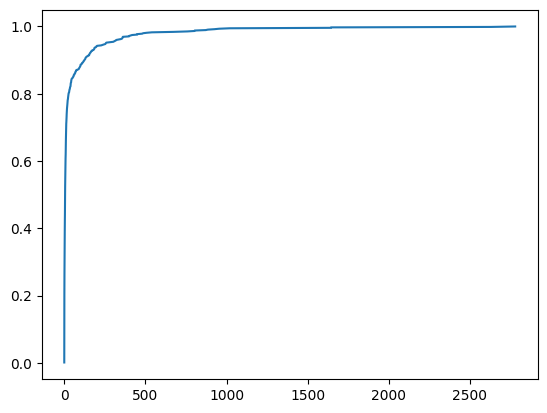

In [29]:
fig, ax1 = plt.subplots(1, 1)

x, y = ecdf(
    [r["ref_shortest_ping_vp"]["d_error"] for r in ref_shortest_ping_results.values()]
)
ax1.plot(x, y, label=f"Reference shortest ping")

# Costs

In [30]:
granularity = "answer_bgp_prefix"
results = eval_results[granularity]

fig, ax1 = plt.subplots(1, 1)

for budget, target_results in results.items():

    x, y = ecdf([len(r["ecs_vps_budget"]) for r in results[budget].values()])
    ax1.plot(x, y, label="ECS selection")

    avg_cost_ecs = round(
        np.mean([[len(r["ecs_vps_budget"]) for r in results[budget].values()]]),
        2,
    )
    median_cost_ecs = round(
        np.median([[len(r["ecs_vps_budget"]) for r in results[budget].values()]]),
        2,
    )

    x, y = ecdf([len(r["filtered_vps_per_cluster"]) for r in results[budget].values()])
    ax1.plot(x, y, label="ECS cluster selection")

    avg_cost_cluster = round(
        np.mean(
            [[len(r["filtered_vps_per_cluster"]) for r in results[budget].values()]]
        ),
        2,
    )
    median_cost_cluster = round(
        np.median(
            [[len(r["filtered_vps_per_cluster"]) for r in results[budget].values()]]
        ),
        2,
    )

    logger.info(f"Measurement cost = {budget}")
    logger.info(f"Avg Measurement cost ECS selection = {avg_cost_ecs}")
    logger.info(f"Median Measurement cost ECS selection = {median_cost_ecs}")
    logger.info(f"Avg Measurement cost cluster selection = {avg_cost_cluster}")
    logger.info(f"Median Measurement cost cluster selection = {median_cost_cluster}")

plt.xlabel("Measurement cost")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.grid()
plt.title(
    f"CDF: Measurement cost",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "measurement_cost_cluster_selection.pdf")
plt.show()

NameError: name 'eval_results' is not defined

In [ ]:
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / "results_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

In [ ]:
granularity = "answer_bgp_prefix"
results = eval_results[granularity]

hostname_filter = load_csv(path_settings.DATASET / "valid_hostnames_cdn.csv")
hostname_filter = [row.split(",")[0] for row in hostname_filter]
hostname_filter = "".join([f",'{h}'" for h in hostname_filter])[1:]
hostname_filter = f"AND hostname IN ({hostname_filter})"

count = 0
costs = []
for target_addr, target_results in eval_results[granularity][50].items():

    target = target_results["target"]
    ref_shortest_ping_vp = target_results["ref_shortest_ping_vp"]
    ecs_shortest_ping_vp = target_results["ecs_shortest_ping_vp"]
    no_ping_vp = target_results["no_ping_vp"]
    no_ping_cluster_vp = target_results["no_ping_cluster_vp"]

    diff_error = ref_shortest_ping_vp["d_error"] - no_ping_vp["d_error"]
    max_score = no_ping_vp["score"]

    if target_results["no_ping_vp"]["d_error"] > 5_00 and max_score > 0.6:

        logger.info("######################################")
        logger.info(f"Target : {target['addr']}")
        logger.info(f"Target BGP prefix : {target['bgp_prefix']}")
        logger.info("######################################")
        logger.info("Reference shortest ping VP:")
        logger.info(f"addr    = {ref_shortest_ping_vp['addr']}")
        logger.info(f"subnet  = {ref_shortest_ping_vp['subnet']}")
        logger.info(f"score   = {ref_shortest_ping_vp['score']}")
        logger.info(f"index   = {ref_shortest_ping_vp['index']}")
        logger.info(f"d error = {ref_shortest_ping_vp['d_error']}")
        logger.info(f"min rtt = {ref_shortest_ping_vp['rtt']}")
        logger.info(
            f"coordinates = {ref_shortest_ping_vp['lat']},{ref_shortest_ping_vp['lon']}"
        )
        logger.info(f"Diff error: {diff_error}")
        logger.info("######################################")
        logger.info("ECS-DNS elected VP:")
        logger.info(f"addr    = {ecs_shortest_ping_vp['addr']}")
        logger.info(f"subnet  = {ecs_shortest_ping_vp['subnet']}")
        logger.info(f"score   = {ecs_shortest_ping_vp['score']}")
        logger.info(f"index   = {ecs_shortest_ping_vp['index']}")
        logger.info(f"d error = {ecs_shortest_ping_vp['d_error']}")
        logger.info(f"min rtt = {ecs_shortest_ping_vp['rtt']}")
        logger.info(
            f"coordinates = {ecs_shortest_ping_vp['lat']},{ecs_shortest_ping_vp['lon']}"
        )
        logger.info("######################################")
        logger.info("No Ping VP:")
        logger.info(f"addr    = {no_ping_vp['addr']}")
        logger.info(f"subnet  = {no_ping_vp['subnet']}")
        logger.info(f"score   = {no_ping_vp['score']}")
        logger.info(f"index   = {no_ping_vp['index']}")
        logger.info(f"d error = {no_ping_vp['d_error']}")
        logger.info(f"min rtt = {no_ping_vp['rtt']}")
        logger.info(f"coordinates = {no_ping_vp['lat']},{no_ping_vp['lon']}")
        logger.info("######################################")
        logger.info("Cluster elected VP:")
        logger.info(f"addr    = {no_ping_cluster_vp['addr']}")
        logger.info(f"subnet  = {no_ping_cluster_vp['subnet']}")
        logger.info(f"score   = {no_ping_cluster_vp['score']}")
        logger.info(f"index   = {no_ping_cluster_vp['index']}")
        logger.info(f"d error = {no_ping_cluster_vp['d_error']}")
        logger.info(f"min rtt = {no_ping_cluster_vp['rtt']}")
        logger.info(
            f"coordinates = {no_ping_cluster_vp['lat']},{no_ping_cluster_vp['lon']}"
        )

        logger.info(f"nb vp selected: {len(target_results['ecs_vps'])}")
        logger.info(f"first vp scores: {target_results['ecs_vps']=}")

        logger.info(
            f"SELECT client_subnet, hostname, answer_subnet, answer_bgp_prefix, pop_ip_info_id, pop_city, pop_country, pop_continent from {clickhouse_settings.DATABASE}.{'old_dns_mapping_with_metadata'} where (client_subnet == toIPv4('{target['subnet']}') OR client_subnet == toIPv4('{ref_shortest_ping_vp['subnet']}') OR client_subnet == toIPv4('{ecs_shortest_ping_vp['subnet']}')) {hostname_filter} order by (hostname, client_subnet)"
        )
        logger.info("######################################")

        count += 1

        # if count > 20:
        #     break

        r_earth = 6378
        d = ecs_shortest_ping_vp["d_error"]
        target_lat, target_lon = target["lat"], target["lon"]
        new_latitude = target_lat + (d / r_earth) * (180 / pi)
        new_longitude = target_lon + (d / r_earth) * (180 / pi) / cos(
            target_lat * pi / 180
        )

        min_lat = target_lat - (d / r_earth) * (180 / pi)
        max_lat = target_lat + (d / r_earth) * (180 / pi)
        min_lon = target_lon - (d / r_earth) * (180 / pi) / cos(target_lat * pi / 180)
        max_lon = target_lon + (d / r_earth) * (180 / pi) / cos(target_lat * pi / 180)

        map = folium.Map(
            location=(target_lat, target_lon),
            zoom_start=6,
            min_lat=min_lat,
            max_lat=max_lat,
            min_lon=min_lon,
            max_lon=max_lon,
        )

        ping_done = 0
        for i, (label, vps) in enumerate(target_results["ecs_vps_per_cluster"].items()):
            for _, vp_lat, vp_lon, _ in vps:
                if label != -1:
                    plotDot(
                        vp_lat,
                        vp_lon,
                        map,
                        color="yellow",
                    )
                else:
                    plotDot(
                        vp_lat,
                        vp_lon,
                        map,
                        color="purple",
                    )

        logger.info(f"True number of VP selected: {ping_done}")

        # for label, vps in ecs_vps_per_cluster.items():
        #     if label == -1:
        #         continue

        #     for vp_addr, vp_lat, vp_lon, score in vps:
        #         max_score_vp_cluster = max(
        #             vp_in_cluster, key=lambda x: x[-1]
        #         )

        #         except KeyError:
        #             continue

        points = [
            (vp[1], vp[2]) for vp in target_results["ecs_vps_per_cluster"].values()
        ]
        if len(points) > 2:
            exterior_points, hull = find_exterior_points(points)
            folium.Polygon(
                locations=exterior_points,
                color="darkblue",
                weight=2,
                fill_color="blue",
                fill_opacity=0.2,
                fill=True,
            ).add_to(map)

            for point in exterior_points:
                plotDot(
                    point[0],
                    point[1],
                    map,
                    color="pink",
                )

        plotDot(
            target_lat,
            target_lon,
            map,
            color="red",
        )
        plotDot(
            ecs_shortest_ping_vp["lat"],
            ecs_shortest_ping_vp["lon"],
            map,
            color="lightblue",
        )
        plotDot(
            ref_shortest_ping_vp["lat"],
            ref_shortest_ping_vp["lon"],
            map,
            color="green",
        )
        plotDot(
            no_ping_vp["lat"],
            no_ping_vp["lon"],
            map,
            color="black",
        )
        plotDot(
            no_ping_cluster_vp["lat"],
            no_ping_cluster_vp["lon"],
            map,
            color="orange",
        )

        display(map)

logger.info(
    f"Number of IP address with wrongful geoloc: {count} ({round(count * 100 / len(targets), 1)} [%])"
)

2024-03-22 09:07:12.508 | INFO     | __main__:<module>:24 - ######################################
2024-03-22 09:07:12.510 | INFO     | __main__:<module>:25 - Target : 23.157.112.130
2024-03-22 09:07:12.511 | INFO     | __main__:<module>:26 - Target BGP prefix : (62538, '23.157.112.0/24')
2024-03-22 09:07:12.512 | INFO     | __main__:<module>:27 - ######################################
2024-03-22 09:07:12.513 | INFO     | __main__:<module>:28 - Reference shortest ping VP:
2024-03-22 09:07:12.514 | INFO     | __main__:<module>:29 - addr    = 23.132.96.169
2024-03-22 09:07:12.514 | INFO     | __main__:<module>:30 - subnet  = 23.132.96.0
2024-03-22 09:07:12.515 | INFO     | __main__:<module>:31 - score   = 0.6670289855072464
2024-03-22 09:07:12.515 | INFO     | __main__:<module>:32 - index   = 61
2024-03-22 09:07:12.516 | INFO     | __main__:<module>:33 - d error = 503.9058793123678
2024-03-22 09:07:12.516 | INFO     | __main__:<module>:34 - min rtt = 1.442455
2024-03-22 09:07:12.517 | IN

2024-03-22 09:07:12.577 | INFO     | __main__:<module>:24 - ######################################
2024-03-22 09:07:12.579 | INFO     | __main__:<module>:25 - Target : 37.46.78.66
2024-03-22 09:07:12.581 | INFO     | __main__:<module>:26 - Target BGP prefix : (15699, '37.46.72.0/21')
2024-03-22 09:07:12.583 | INFO     | __main__:<module>:27 - ######################################
2024-03-22 09:07:12.584 | INFO     | __main__:<module>:28 - Reference shortest ping VP:
2024-03-22 09:07:12.585 | INFO     | __main__:<module>:29 - addr    = 185.161.96.30
2024-03-22 09:07:12.586 | INFO     | __main__:<module>:30 - subnet  = 185.161.96.0
2024-03-22 09:07:12.588 | INFO     | __main__:<module>:31 - score   = 0.656989247311828
2024-03-22 09:07:12.588 | INFO     | __main__:<module>:32 - index   = 127
2024-03-22 09:07:12.590 | INFO     | __main__:<module>:33 - d error = 31.68303955543404
2024-03-22 09:07:12.591 | INFO     | __main__:<module>:34 - min rtt = 1.399245
2024-03-22 09:07:12.592 | INFO  

2024-03-22 09:07:12.650 | INFO     | __main__:<module>:24 - ######################################
2024-03-22 09:07:12.651 | INFO     | __main__:<module>:25 - Target : 45.121.208.237
2024-03-22 09:07:12.652 | INFO     | __main__:<module>:26 - Target BGP prefix : (137409, '45.121.208.0/24')
2024-03-22 09:07:12.653 | INFO     | __main__:<module>:27 - ######################################
2024-03-22 09:07:12.654 | INFO     | __main__:<module>:28 - Reference shortest ping VP:
2024-03-22 09:07:12.656 | INFO     | __main__:<module>:29 - addr    = 203.100.61.93
2024-03-22 09:07:12.657 | INFO     | __main__:<module>:30 - subnet  = 203.100.61.0
2024-03-22 09:07:12.658 | INFO     | __main__:<module>:31 - score   = 0.6712522045855379
2024-03-22 09:07:12.659 | INFO     | __main__:<module>:32 - index   = 70
2024-03-22 09:07:12.660 | INFO     | __main__:<module>:33 - d error = 5.883583128031072
2024-03-22 09:07:12.661 | INFO     | __main__:<module>:34 - min rtt = 1.031604
2024-03-22 09:07:12.662 | 

ValueError: could not convert string to float: '180.150.117.30'

In [ ]:
examples = [
    "79.142.69.12",
    "5.57.16.65",
    "23.157.112.130",
    "41.221.208.94",
    "45.142.246.158",
    "74.119.118.17",
]